In [ ]:
import os
import numpy as np
import random
from PIL import Image, ImageEnhance
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Flatten, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from sklearn.utils import shuffle

In [ ]:
train_dir = '/content/drive/MyDrive/MRI Images/Training/'
test_dir = '/content/drive/MyDrive/MRI Images/Testing/'

train_paths = []
train_labels = []
for label in os.listdir(train_dir):
    for image in os.listdir(os.path.join(train_dir, label)):
        train_paths.append(os.path.join(train_dir, label, image))
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

test_paths = []
test_labels = []
for label in os.listdir(test_dir):
    for image in os.listdir(os.path.join(test_dir, label)):
        test_paths.append(os.path.join(test_dir, label, image))
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

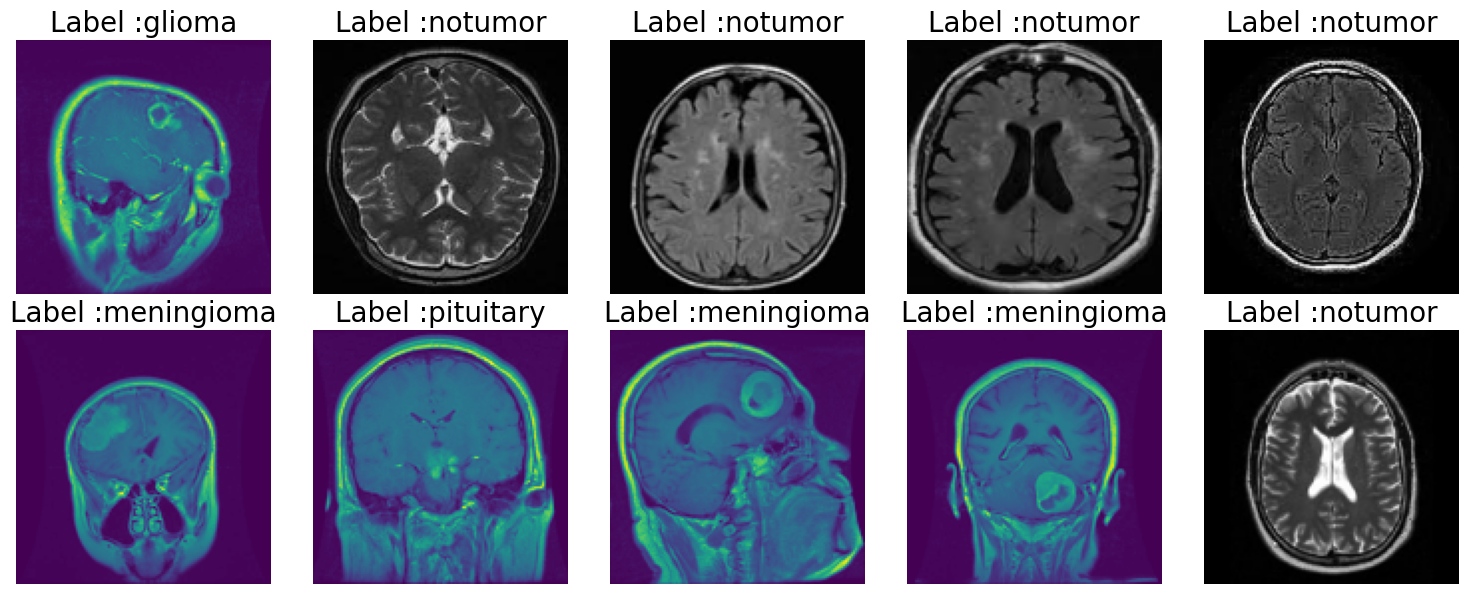

In [ ]:
import random
import matplotlib.pyplot as plt

random_indices = random.sample(range(len(train_paths)), 10)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()

for i, idx in enumerate(random_indices):
    img_path = train_paths[idx]
    img = Image.open(img_path)
    img = img.resize((128, 128))

    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f"Label :{train_labels[idx]}", fontsize = 20)

plt.tight_layout()
plt.show()

In [ ]:
def augment_image(image):
  image = Image.fromarray(np.uint8(image))
  image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))
  image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))
  image = np.array(image)/255.0
  return image

def open_images(paths):
  images = []
  for path in paths:
    img = load_img(path, target_size = (Image_size, Image_size))
    img = ImageEnhance.Brightness(img).enhance(random.uniform(0.8, 1.2))
    img = ImageEnhance.Contrast(img).enhance(random.uniform(0.8, 1.2))
    img = np.array(img)/255.0
    images.append(img)
  return np.array(images)

def encode_label(labels):
  unique_labels = sorted(os.listdir(train_dir)) # Ensure consistent order
  encoded = [unique_labels.index(label) for label in labels]
  return np.array(encoded)

def datagen(paths, labels, batch_size = 12, epochs = 1):
  unique_labels = sorted(os.listdir(train_dir)) # Get unique labels once
  for epoch in range(epochs):
    for i in range(0, len(paths), batch_size):
      batch_paths = paths[i:i+batch_size]
      batch_images = open_images(batch_paths)
      batch_labels = labels[i:i+batch_size]
      batch_labels_encoded = [unique_labels.index(label) for label in batch_labels]
      yield batch_images, np.array(batch_labels_encoded)

In [ ]:
Image_size = 128
base_model = VGG16(input_shape = (Image_size, Image_size, 3), include_top = False, weights = 'imagenet')

for layer in base_model.layers:
  layer.trainable = False

base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

model = Sequential()
model.add(Input(shape = (Image_size, Image_size, 3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3))

model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(len(os.listdir(train_dir)), activation = 'softmax'))

model.compile(optimizer = Adam(learning_rate = 0.0001), loss = 'sparse_categorical_crossentropy', metrics = ['sparse_categorical_accuracy'])

batch_size = 20
steps = int(len(train_paths)/batch_size)
epochs = 5

history = model.fit(datagen(train_paths, train_labels, batch_size = batch_size, epochs = epochs), epochs = epochs, steps_per_epoch = steps)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 1812s 6s/step - loss: 0.6832 - sparse_categorical_accuracy: 0.7240
Epoch 2/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 36s 99ms/step - loss: 0.2582 - sparse_categorical_accuracy: 0.9036
Epoch 3/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 28s 100ms/step - loss: 0.1659 - sparse_categorical_accuracy: 0.9308
Epoch 4/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 28s 98ms/step - loss: 0.1173 - sparse_categorical_accuracy: 0.9568
Epoch 5/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 28s 98ms/step - loss: 0.0867 - sparse_categorical_accuracy: 0.9663


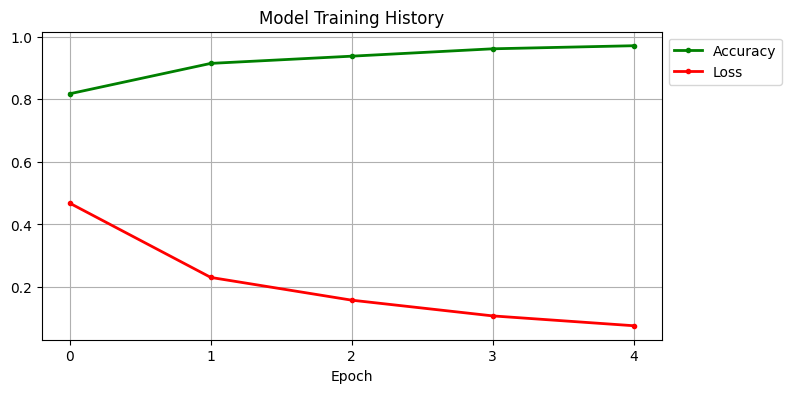

In [ ]:
plt.figure(figsize = (8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth = 2)
plt.plot(history.history['loss'], '.r-', linewidth = 2)
plt.title('Model Training History')
plt.xlabel('Epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc = 'upper left', bbox_to_anchor = (1,1))
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize

test_images = open_images(test_paths)
test_labels_encoded = encode_label(test_labels)

test_predictions = model.predict(test_images)

print("Classification Report:")
print(classification_report(test_labels_encoded, np.argmax(test_predictions, axis = 1)))

41/41 ━━━━━━━━━━━━━━━━━━━━ 14s 196ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.90      0.94       300
           1       0.90      0.98      0.94       306
           2       1.00      1.00      1.00       405
           3       0.99      0.97      0.98       300

    accuracy                           0.97      1311
   macro avg       0.97      0.96      0.96      1311
weighted avg       0.97      0.97      0.97      1311



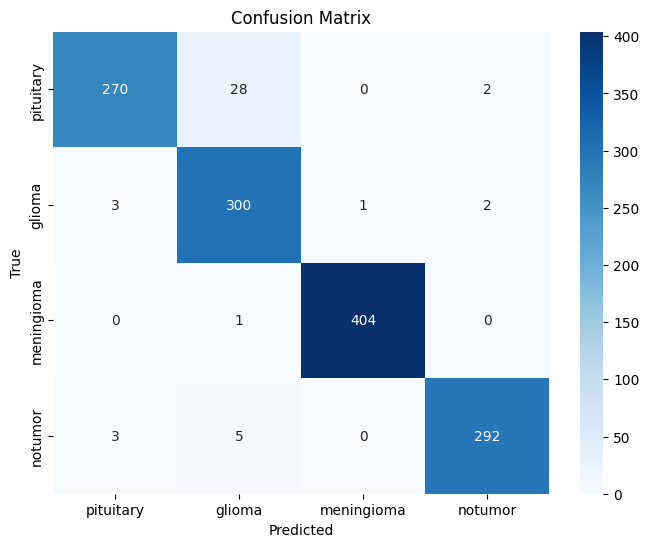

In [ ]:
conf_matrix = confusion_matrix(test_labels_encoded, np.argmax(test_predictions, axis = 1))

plt.figure(figsize = (8,6))
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = os.listdir(train_dir), yticklabels = os.listdir(train_dir))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
model.save('model.h5')

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('model.h5')

In [ ]:
from keras.preprocessing.image import load_img, img_to_array

class_labels = sorted(os.listdir(train_dir))

def detect_and_display(image_path, model):
  try:
    img = load_img(image_path, target_size = (Image_size, Image_size))
    img_array = img_to_array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis = 0)  # Corrected: img_array instead of img

    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions[0])
    confidence_score = np.max(predictions[0])
    predicted_class_label = class_labels[predicted_class_index]

    if predicted_class_label == 'notumour': # Corrected: Use class_labels to compare
      result = "No Tumour Detected"
    else:
      result = f"Tumour Detected: {predicted_class_label.capitalize()}"

    plt.imshow(load_img(image_path)) # Corrected: Use image_path for displaying original image
    plt.axis('off')
    plt.title(f"{result}\nConfidence: {confidence_score * 100:.2f}%")
    plt.show()

  except Exception as e:
    print("Error processing the image:", str(e)) # Corrected: Fixed syntax error

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


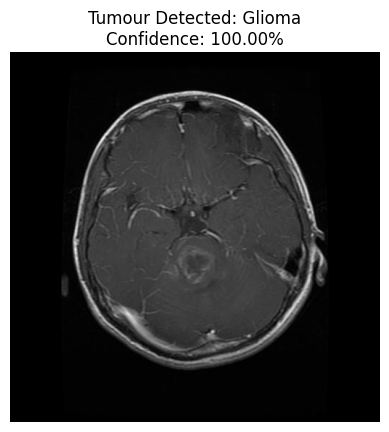

In [ ]:
image_path = '/content/drive/MyDrive/MRI Images/Testing/glioma/Te-glTr_0007.jpg'
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


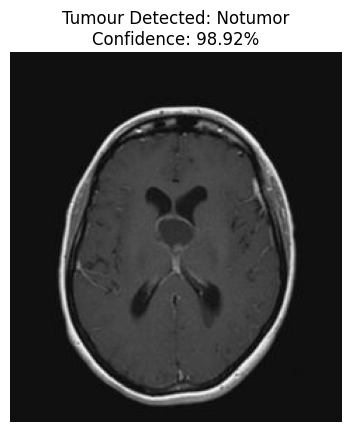

In [ ]:
image_path = '/content/drive/MyDrive/MRI Images/Testing/notumor/Te-no_0035.jpg'
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


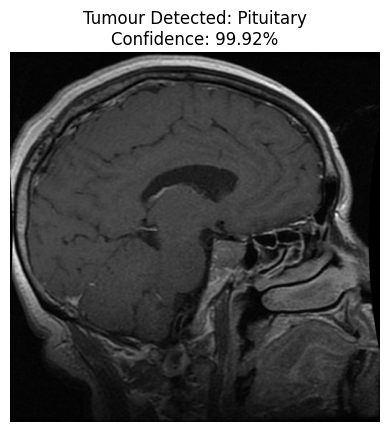

In [ ]:
image_path = '/content/drive/MyDrive/MRI Images/Testing/pituitary/Te-pi_0097.jpg'
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


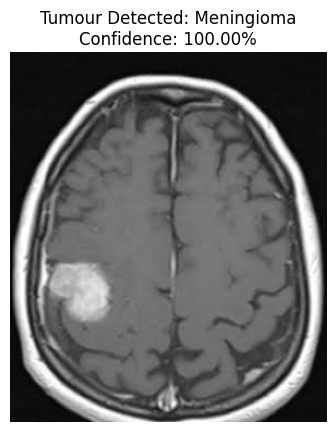

In [ ]:
image_path = '/content/drive/MyDrive/MRI Images/Testing/meningioma/Te-me_0023.jpg'
detect_and_display(image_path, model)